##Mount Goolge Drive

In [1]:
# link to google drive

#from google.colab import drive
#drive.mount('/content/gdrive/')
#drive.mount("/content/gdrive/", force_remount=True)

### Ejecutar Codigo en Google Drive

In [2]:
#%cd "/content/gdrive/My Drive/Deep_Network_unmixing/version_1"

In [2]:
%ls
import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib as mpl
import matplotlib.pyplot as plt

BGU_9.mat                         MAIN.py
end4_Abundance.fig                Main_settings_parameters.ipynb
end4.mat                          __pycache__/
end4_Materials.fig                Results/
Endm_1.mat                        Run_Colab_last.ipynb
Endm_2.mat                        RunColab_unmixing_2.ipynb
H1Shot.mat                        RunColab_unmixing_2V3.ipynb
HJasper1ShotCASSI.mat             RunColab_unmixing.ipynb
Initial_endmemebers/              RunColabV4_final.ipynb
LegoCars.mat                      Script.ipynb
Main_Input_network_setting.ipynb  srPaviaCenter.mat
Main_number_of_Endmembers.ipynb


# Data Set
shows the dataset details

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 150, 150, 102)


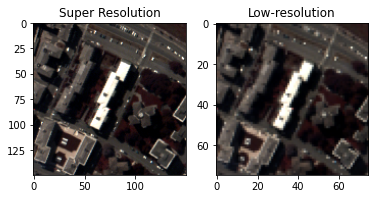

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5ae65c7a10>,
 Text(0.5, 1.0, 'Low-resolution'),
 None)

In [3]:
Hy = scipy.io.loadmat('srPaviaCenter.mat')['HR']
[m,n,l] = Hy.shape
Hy = tf.expand_dims(Hy,0)
print(Hy.shape)

Endm_load_1 = scipy.io.loadmat('Endm_1.mat')['Endm']
Endm_load_2 = scipy.io.loadmat('Endm_2.mat')['Endm']

Hy = Hy.numpy()
most = np.squeeze(Hy)[:,:,[25,16,8]]*2
plt.subplot(1,2,1),plt.imshow(most), plt.title('Super Resolution')

def Desimation_Super(x,factor,w):
    Aux = tf.image.resize(x,[int(np.round(w/factor)),int(np.round(w/factor))])
    return Aux

y = Desimation_Super(Hy,2,m)
pp = np.squeeze(y)
pp = pp[:,:,[25,16,8]]*2
plt.subplot(1,2,2),plt.imshow(pp), plt.title('Low-resolution'),plt.show()





# Resutls Linear Model_ with Abund_Net



In [4]:
from MAIN import *
import os.path as path

def LMM_Net_reconstruction(pretrained_weights=None, input_size = (150,150,1), L=102, fact = 0.5, rank = 8,Layer_depth=16,number_layer=4,initial=None, decimation=2):
    inputs = Input(input_size)
    inicial = XoLayer(largo=input_size[0], ancho=input_size[1], profun=L, fact=fact)(inputs)
    drop1 = Dropout(0.2)(inicial)

    Ab = Abund_net(drop1,rank,L=Layer_depth,number_layer=number_layer)
    hy = Endmemebers_Layer(L=L, rank=rank,initicial=initial)(Ab)
    final =Lambda(lambda x: Desimation_Super(x,decimation,input_size[0])) (hy)

    model = Model(inputs, [final,Ab])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

In [5]:
# prepared folders
Path = 'Results'
try:
  os.stat(Path)
except:
  os.mkdir(Path)

# Second experiment:
  - Type of Inputs:
      1. Learnable input following rho values
      2. Fixed as Noise
      3. Gradiends
      4. Constants


 ### Lerneable


In [7]:
# Important Parameter and Hyper-parameters
learning_rate_value = [5e-3, 2e-3, 1e-3]
rho_values = [0.1,0.2,0.3,0.4,0.5, 0.6,0.7,0.8,0.9]

# fixed for now
regularization_abund = 1
rank = 8
Abundance_layer = [32] # for a fixed 5 layer
Number_layers  = [4]
show_every = 50
Global_max_epoch = 500
psnr_deep = []
best_psnr = 0
Best_metric = []
plot_results = 0

for Abun_layer in Abundance_layer:
    for layer_num in Number_layers:
        for lrn in learning_rate_value:
            for rho in rho_values:
                psnr_deep = []
                best_psnr = 0
                Best_metric = []
                Info_path = 'Learning_with_rho='+str(rho)+'lr='+str(lrn)+'Num_layer='+str(layer_num)+'Depth_layer='+str(Abun_layer);
                Real_path = (Path+'/'+Info_path)
                try:
                    os.stat(Real_path)
                except:
                    os.mkdir(Real_path)

                # Model values
                model = LMM_Net_reconstruction(input_size =(m,n,l), L=l, fact=rho,rank=rank,Layer_depth=Abun_layer,number_layer=layer_num)
                # Optimization parameters
                optimizad = tf.keras.optimizers.Adam(learning_rate=lrn, beta_1=0.9, beta_2=0.9, amsgrad=False);
                model.compile(optimizer=optimizad, loss=['mean_squared_error', Abundance_loss()],loss_weights=[1,regularization_abund])

                contad_decr = 0
                for i in range(Global_max_epoch):
                    print('Iteration = ' + str(i)+' of max= '+str(Global_max_epoch)+ Info_path +'\n')
                    clear_output(wait=True)
                    model.fit(np.zeros(shape=(1,m,n,l)), [y, np.ones((1,m,n))], epochs = show_every,batch_size=1,verbose=0)

                    # ouputs Models
                    temporal = model.get_weights()
                    Endm = np.squeeze(temporal[-1]) # aca cambio
                    H_high = K.function([model.layers[0].input], [model.get_layer('Abund_final').output])
                    Image_recon = K.function([model.layers[0].input], [model.layers[-2].output])
                    Img_recon = np.squeeze(np.asarray(Image_recon(Hy)))
                    rest_h = np.squeeze(np.asarray(H_high(Hy)))

                    # evaluation model
                    results_metrics=performance(np.squeeze(Hy),Img_recon)
                    psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

                    if(plot_results==1):
                        pp = Img_recon[:,:,[25,16,8]]*2
                        plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
                        plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB')
                        plt.show()
                        plt.subplot(1, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
                        plt.subplot(1, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
                        plt.subplot(1, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
                        plt.subplot(1, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')
                        plt.show()

                        plt.subplot(1,1,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
                        plt.show()

                        plt.plot(psnr_deep),plt.title('PSNR vs Iterations'),plt.xlabel('Iteration'),
                        plt.ylabel('PSNR'),plt.show()
                    
                    if(best_psnr>psnr_deep[-1]):
                        contad_decr +=1
                    else:
                        best_psnr = psnr_deep[-1]
                        best_Endm = Endm
                        Best_metric = results_metrics
                        best_Abun = rest_h
                        best_img  = Img_recon
                        contad_decr = 0

                    print('PNSR = '+ str(psnr_deep[-1])+ ', contador_decr= ' + str(contad_decr)+ ', best= ' + str(best_psnr)+'\n')
                    
                    if (contad_decr>30):
                        scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                        scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                        #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                        break
                else:
                    scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                    scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                    #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                    continue

                scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)

scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
#save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-7-f72a2323d43e>, line 104)

# Fixed as Noise

In [ ]:
def LMM_Net_reconstruction(pretrained_weights=None, input_size = (150,150,1), L=102, fact = 0.5, rank = 8,Layer_depth=16,number_layer=4,initial=None, decimation=2):
    inputs = Input(input_size)

    Ab = Abund_net(inputs,rank,L=Layer_depth,number_layer=number_layer)
    hy = Endmemebers_Layer(L=L, rank=rank,initicial=initial)(Ab)
    final =Lambda(lambda x: Desimation_Super(x,decimation,input_size[0])) (hy)

    model = Model(inputs, [final,Ab])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

In [ ]:
# Important Parameter and Hyper-parameters
learning_rate_value = [5e-3, 2e-3, 1e-3]
Perturbed = [0,0.01,0.03,0.05,0.08,0.1]

# fixed for now
regularization_abund = 1
rank = 8
Abundance_layer = [32] # for a fixed 5 layer
Number_layers  = [4]
show_every = 50
Global_max_epoch = 500
psnr_deep = []
best_psnr = 0
Best_metric = []
plot_results = 0

for Abun_layer in Abundance_layer:
    for layer_num in Number_layers:
        for lrn in learning_rate_value:
            for rho in Perturbed:
                psnr_deep = []
                best_psnr = 0
                Best_metric = []
                Info_path = 'Fixed_as_Noise_perturbed='+str(rho)+'lr='+str(lrn)+'Num_layer='+str(layer_num)+'Depth_layer='+str(Abun_layer);
                Real_path = (Path+'/'+Info_path)
                try:
                    os.stat(Real_path)
                except:
                    os.mkdir(Real_path)

                # Model values
                model = LMM_Net_reconstruction(input_size =(m,n,l), L=l, fact=rho,rank=rank,Layer_depth=Abun_layer,number_layer=layer_num)
                Input_v = np.random.uniform(0,1,(1,m,n,l))
                # Optimization parameters
                optimizad = tf.keras.optimizers.Adam(learning_rate=lrn, beta_1=0.9, beta_2=0.9, amsgrad=False);
                model.compile(optimizer=optimizad, loss=['mean_squared_error', Abundance_loss()],loss_weights=[1,regularization_abund])

                contad_decr = 0
                for i in range(Global_max_epoch):
                    print('Iteration = ' + str(i)+' of max= '+str(Global_max_epoch)+ Info_path +'\n')
                    clear_output(wait=True)
                    if(rho>0):
                      input_ent = Input_v + rho*np.random.normal(0,1,(1,m,n,l))
                    else:
                      input_ent = Input_v
                    model.fit(input_ent, [y, np.ones((1,m,n))], epochs = show_every,batch_size=1,verbose=0)

                    # ouputs Models
                    temporal = model.get_weights()
                    Endm = np.squeeze(temporal[-1]) # aca cambio
                    H_high = K.function([model.layers[0].input], [model.get_layer('Abund_final').output])
                    Image_recon = K.function([model.layers[0].input], [model.layers[-2].output])
                    Img_recon = np.squeeze(np.asarray(Image_recon(input_ent)))
                    rest_h = np.squeeze(np.asarray(H_high(input_ent)))

                    # evaluation model
                    results_metrics=performance(np.squeeze(Hy),Img_recon)
                    psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

                    if(plot_results==1):
                        pp = Img_recon[:,:,[25,16,8]]*2
                        plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
                        plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB')
                        plt.show()
                        plt.subplot(1, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
                        plt.subplot(1, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
                        plt.subplot(1, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
                        plt.subplot(1, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')
                        plt.show()

                        plt.subplot(1,1,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
                        plt.show()

                        plt.plot(psnr_deep),plt.title('PSNR vs Iterations'),plt.xlabel('Iteration'),
                        plt.ylabel('PSNR'),plt.show()
                    
                    if(best_psnr>psnr_deep[-1]):
                        contad_decr +=1
                    else:
                        best_psnr = psnr_deep[-1]
                        best_Endm = Endm
                        Best_metric = results_metrics
                        best_Abun = rest_h
                        best_img  = Img_recon
                        contad_decr = 0

                    print('PNSR = '+ str(psnr_deep[-1])+ ', contador_decr= ' + str(contad_decr)+ ', best= ' + str(best_psnr)+'\n')
                    
                    if (contad_decr>30):
                        scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                        scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                        #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                        break
                else:
                    scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                    scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                    #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                    continue

                scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)

scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
#save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)

# As gradients

In [ ]:
x = np.linspace(0, 1, m)
xx, yy = np.meshgrid(x, x)
plt.subplot(121),plt.imshow(xx),plt.subplot(122),plt.imshow(yy)

Inp = np.concatenate((np.expand_dims(xx,-1),np.expand_dims(yy,-1)),axis=2)
Inp = np.expand_dims(Inp,0)
Inp.shape

In [ ]:
# Important Parameter and Hyper-parameters
learning_rate_value = [5e-3,2e-3, 1e-3]
Perturbed = [0,0.01,0.03,0.05,0.08,0.1]

# fixed for now
regularization_abund = 1
rank = 8
Abundance_layer = [32] # for a fixed 5 layer
Number_layers  = [4]
show_every = 50
Global_max_epoch = 500
psnr_deep = []
best_psnr = 0
Best_metric = []
plot_results = 0

for Abun_layer in Abundance_layer:
    for layer_num in Number_layers:
        for lrn in learning_rate_value:
            for rho in Perturbed:
                psnr_deep = []
                best_psnr = 0
                Best_metric = []
                Info_path = 'Gradient_perturbed='+str(rho)+'lr='+str(lrn)+'Num_layer='+str(layer_num)+'Depth_layer='+str(Abun_layer);
                Real_path = (Path+'/'+Info_path)
                try:
                    os.stat(Real_path)
                except:
                    os.mkdir(Real_path)

                # Model values
                model = LMM_Net_reconstruction(input_size =(m,n,2), L=l, fact=rho,rank=rank,Layer_depth=Abun_layer,number_layer=layer_num)
                Input_v = Inp
                # Optimization parameters
                optimizad = tf.keras.optimizers.Adam(learning_rate=lrn, beta_1=0.9, beta_2=0.9, amsgrad=False);
                model.compile(optimizer=optimizad, loss=['mean_squared_error', Abundance_loss()],loss_weights=[1,regularization_abund])

                contad_decr = 0
                for i in range(Global_max_epoch):
                    print('Iteration = ' + str(i)+' of max= '+str(Global_max_epoch)+ Info_path +'\n')
                    clear_output(wait=True)
                    if(rho>0):
                      input_ent = Input_v + rho*np.random.normal(0,1,(1,m,n,2))
                    else:
                      input_ent = Input_v
                    model.fit(input_ent, [y, np.ones((1,m,n))], epochs = show_every,batch_size=1,verbose=0)

                    # ouputs Models
                    temporal = model.get_weights()
                    Endm = np.squeeze(temporal[-1]) # aca cambio
                    H_high = K.function([model.layers[0].input], [model.get_layer('Abund_final').output])
                    Image_recon = K.function([model.layers[0].input], [model.layers[-2].output])
                    Img_recon = np.squeeze(np.asarray(Image_recon(input_ent)))
                    rest_h = np.squeeze(np.asarray(H_high(input_ent)))

                    # evaluation model
                    results_metrics=performance(np.squeeze(Hy),Img_recon)
                    psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

                    if(plot_results==1):
                        pp = Img_recon[:,:,[25,16,8]]*2
                        plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
                        plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB')
                        plt.show()
                        plt.subplot(1, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
                        plt.subplot(1, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
                        plt.subplot(1, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
                        plt.subplot(1, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')
                        plt.show()

                        plt.subplot(1,1,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
                        plt.show()

                        plt.plot(psnr_deep),plt.title('PSNR vs Iterations'),plt.xlabel('Iteration'),
                        plt.ylabel('PSNR'),plt.show()
                    
                    if(best_psnr>psnr_deep[-1]):
                        contad_decr +=1
                    else:
                        best_psnr = psnr_deep[-1]
                        best_Endm = Endm
                        Best_metric = results_metrics
                        best_Abun = rest_h
                        best_img  = Img_recon
                        contad_decr = 0

                    print('PNSR = '+ str(psnr_deep[-1])+ ', contador_decr= ' + str(contad_decr)+ ', best= ' + str(best_psnr)+'\n')
                    
                    if (contad_decr>30):
                        scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                        scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                        #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                        break
                else:
                    scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                    scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                    #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                    continue

                scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)

scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
#save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)

# Constant

In [ ]:
# Important Parameter and Hyper-parameters
learning_rate_value = [5e-3,2e-3, 1e-3]
Perturbed = [0,0.01,0.03,0.05,0.08,0.1]

# fixed for now
regularization_abund = 1
rank = 8
Abundance_layer = [32] # for a fixed 5 layer
Number_layers  = [4]
show_every = 50
Global_max_epoch = 500
psnr_deep = []
best_psnr = 0
Best_metric = []
plot_results = 0

for Abun_layer in Abundance_layer:
    for layer_num in Number_layers:
        for lrn in learning_rate_value:
            for rho in Perturbed:
                psnr_deep = []
                best_psnr = 0
                Best_metric = []
                Info_path = 'Constant_perturbed='+str(rho)+'lr='+str(lrn)+'Num_layer='+str(layer_num)+'Depth_layer='+str(Abun_layer);
                Real_path = (Path+'/'+Info_path)
                try:
                    os.stat(Real_path)
                except:
                    os.mkdir(Real_path)

                # Model values
                model = LMM_Net_reconstruction(input_size =(m,n,l), L=l, fact=rho,rank=rank,Layer_depth=Abun_layer,number_layer=layer_num)
                Input_v = np.ones((1,m,n,l))*0.5
                # Optimization parameters
                optimizad = tf.keras.optimizers.Adam(learning_rate=lrn, beta_1=0.9, beta_2=0.9, amsgrad=False);
                model.compile(optimizer=optimizad, loss=['mean_squared_error', Abundance_loss()],loss_weights=[1,regularization_abund])

                contad_decr = 0
                for i in range(Global_max_epoch):
                    print('Iteration = ' + str(i)+' of max= '+str(Global_max_epoch)+ Info_path +'\n')
                    clear_output(wait=True)
                    if(rho>0):
                      input_ent = Input_v + rho*np.random.normal(0,1,(1,m,n,l))
                    else:
                      input_ent = Input_v
                    model.fit(input_ent, [y, np.ones((1,m,n))], epochs = show_every,batch_size=1,verbose=0)

                    # ouputs Models
                    temporal = model.get_weights()
                    Endm = np.squeeze(temporal[-1]) # aca cambio
                    H_high = K.function([model.layers[0].input], [model.get_layer('Abund_final').output])
                    Image_recon = K.function([model.layers[0].input], [model.layers[-2].output])
                    Img_recon = np.squeeze(np.asarray(Image_recon(input_ent)))
                    rest_h = np.squeeze(np.asarray(H_high(input_ent)))

                    # evaluation model
                    results_metrics=performance(np.squeeze(Hy),Img_recon)
                    psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

                    if(plot_results==1):
                        pp = Img_recon[:,:,[25,16,8]]*2
                        plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
                        plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB')
                        plt.show()
                        plt.subplot(1, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
                        plt.subplot(1, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
                        plt.subplot(1, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
                        plt.subplot(1, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')
                        plt.show()

                        plt.subplot(1,1,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
                        plt.show()

                        plt.plot(psnr_deep),plt.title('PSNR vs Iterations'),plt.xlabel('Iteration'),
                        plt.ylabel('PSNR'),plt.show()
                    
                    if(best_psnr>psnr_deep[-1]):
                        contad_decr +=1
                    else:
                        best_psnr = psnr_deep[-1]
                        best_Endm = Endm
                        Best_metric = results_metrics
                        best_Abun = rest_h
                        best_img  = Img_recon
                        contad_decr = 0

                    print('PNSR = '+ str(psnr_deep[-1])+ ', contador_decr= ' + str(contad_decr)+ ', best= ' + str(best_psnr)+'\n')
                    
                    if (contad_decr>30):
                        scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                        scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                        #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                        break
                else:
                    scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                    scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                    #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                    continue

                scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)

scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
#save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Inicialization

In [6]:
Input_v = tf.image.resize(y,[m,n]).numpy()


In [ ]:
# Important Parameter and Hyper-parameters
learning_rate_value = [5e-3,2e-3, 1e-3]
Perturbed = [0,0.01,0.03,0.05,0.08,0.1]

# fixed for now
regularization_abund = 1
rank = 8
Abundance_layer = [32] # for a fixed 5 layer
Number_layers  = [4]
show_every = 50
Global_max_epoch = 500
psnr_deep = []
best_psnr = 0
Best_metric = []
plot_results = 0

for Abun_layer in Abundance_layer:
    for layer_num in Number_layers:
        for lrn in learning_rate_value:
            for rho in Perturbed:
                psnr_deep = []
                best_psnr = 0
                Best_metric = []
                Info_path = 'Inicialization_perturbed='+str(rho)+'lr='+str(lrn)+'Num_layer='+str(layer_num)+'Depth_layer='+str(Abun_layer);
                Real_path = (Path+'/'+Info_path)
                try:
                    os.stat(Real_path)
                except:
                    os.mkdir(Real_path)

                # Model values
                model = LMM_Net_reconstruction(input_size =(m,n,l), L=l, fact=rho,rank=rank,Layer_depth=Abun_layer,number_layer=layer_num)

                # Optimization parameters
                optimizad = tf.keras.optimizers.Adam(learning_rate=lrn, beta_1=0.9, beta_2=0.9, amsgrad=False);
                model.compile(optimizer=optimizad, loss=['mean_squared_error', Abundance_loss()],loss_weights=[1,regularization_abund])

                contad_decr = 0
                for i in range(Global_max_epoch):
                    print('Iteration = ' + str(i)+' of max= '+str(Global_max_epoch)+ Info_path +'\n')
                    clear_output(wait=True)
                    if(rho>0):
                      input_ent = Input_v + rho*np.random.normal(0,1,(1,m,n,l))
                    else:
                      input_ent = Input_v
                    model.fit(input_ent, [y, np.ones((1,m,n))], epochs = show_every,batch_size=1,verbose=0)

                    # ouputs Models
                    temporal = model.get_weights()
                    Endm = np.squeeze(temporal[-1]) # aca cambio
                    H_high = K.function([model.layers[0].input], [model.get_layer('Abund_final').output])
                    Image_recon = K.function([model.layers[0].input], [model.layers[-2].output])
                    Img_recon = np.squeeze(np.asarray(Image_recon(input_ent)))
                    rest_h = np.squeeze(np.asarray(H_high(input_ent)))

                    # evaluation model
                    results_metrics=performance(np.squeeze(Hy),Img_recon)
                    psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

                    if(plot_results==1):
                        pp = Img_recon[:,:,[25,16,8]]*2
                        plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
                        plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB')
                        plt.show()
                        plt.subplot(1, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
                        plt.subplot(1, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
                        plt.subplot(1, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
                        plt.subplot(1, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')
                        plt.show()

                        plt.subplot(1,1,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
                        plt.show()

                        plt.plot(psnr_deep),plt.title('PSNR vs Iterations'),plt.xlabel('Iteration'),
                        plt.ylabel('PSNR'),plt.show()

                    if(best_psnr>psnr_deep[-1]):
                        contad_decr +=1
                    else:
                        best_psnr = psnr_deep[-1]
                        best_Endm = Endm
                        Best_metric = results_metrics
                        best_Abun = rest_h
                        best_img  = Img_recon
                        contad_decr = 0

                    print('PNSR = '+ str(psnr_deep[-1])+ ', contador_decr= ' + str(contad_decr)+ ', best= ' + str(best_psnr)+'\n')

                    if (contad_decr>30):
                        scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                        scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                        #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                        break
                else:
                    scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                    scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                    #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                    continue

                scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)

scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
#save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
